In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

# PART 1

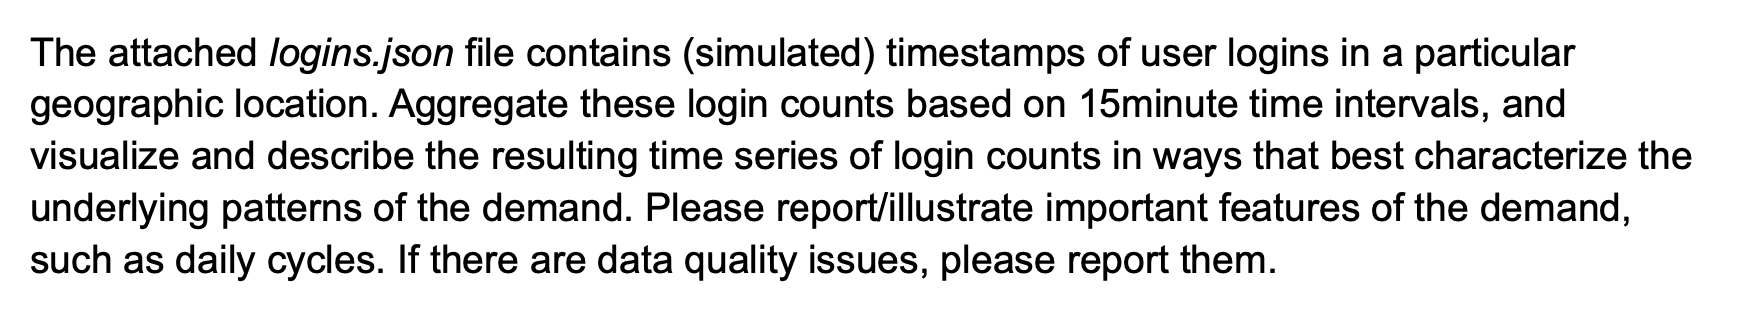

In [152]:
# Read in logins data
logins = pd.read_json('logins.json')
logins

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [153]:
# Group the data by login_time at 15 minute intervals.
# We apply the .size() method to get a count of logins within each interval
interval_counts = logins.groupby(pd.Grouper(key='login_time',freq='15Min',origin='start')).size().to_frame('counts')
interval_counts

,counts
login_time,
1970-01-01 20:12:16,8
1970-01-01 20:27:16,8
1970-01-01 20:42:16,6
1970-01-01 20:57:16,3
1970-01-01 21:12:16,3
...,...
1970-04-13 17:57:16,4
1970-04-13 18:12:16,4
1970-04-13 18:27:16,5


In [178]:
interval_counts['hour'] = interval_counts.index.hour
interval_counts['weekday'] = interval_counts.index.day_name()
interval_counts['month'] = interval_counts.index.month
interval_counts['week'] = interval_counts.index.isocalendar().week

interval_counts.head()

,counts,weekday,month,week,hour
login_time,,,,,
1970-01-01 20:12:16,8,Thursday,1,1,20
1970-01-01 20:27:16,8,Thursday,1,1,20
1970-01-01 20:42:16,6,Thursday,1,1,20
1970-01-01 20:57:16,3,Thursday,1,1,20
1970-01-01 21:12:16,3,Thursday,1,1,21


In [186]:
interval_counts.groupby('weekday').agg({'counts': ['sum','mean']})

counts           
             sum       mean
weekday                    
Friday     15246  10.587500
Monday      8836   6.222535
Saturday   19347  13.435417
Sunday     18062  12.543056
Thursday   11983   8.811029
Tuesday     9284   6.907738
Wednesday  10384   7.726190

In [187]:
interval_counts.groupby('hour').agg({'counts': ['sum','mean']})

counts           
        sum       mean
hour                  
0      6048  14.823529
1      6311  15.468137
2      5577  13.669118
3      4735  11.605392
4      5095  12.487745
5      2255   5.526961
6      1011   2.477941
7       796   1.950980
8       855   2.095588
9      1766   4.328431
10     3587   8.791667
11     5906  14.475490
12     4632  11.352941
13     3476   8.519608
14     3467   8.497549
15     2964   7.264706
16     2773   6.796569
17     2648   6.490196
18     3044   7.460784
19     3288   8.138614
20     4429  10.855392
21     5943  14.566176
22     6544  16.039216
23     5992  14.686275

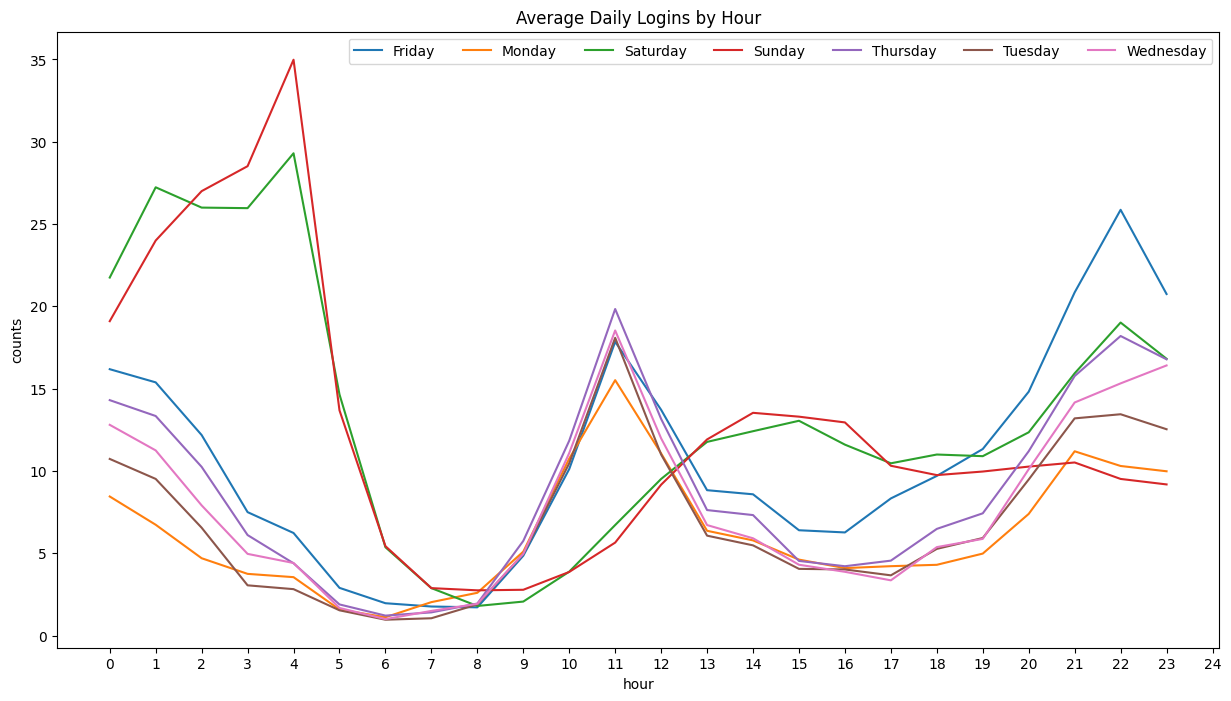

In [200]:
avg_logins = interval_counts.groupby(['hour','weekday'])['counts'].mean().reset_index()

plt.figure(figsize=(15,8))
ax = sns.lineplot(data=avg_logins, x='hour', y='counts', hue='weekday')
ax.legend(loc="upper right", ncol=8)
plt.title('Average Daily Logins by Hour')
plt.xticks(range(0,25))
plt.show()

### Observations

1. The highest number of logins happens on the weekends (Saturday and Sunday)
2. On average, there is a spike in logins during two different time intervals. From 10PM until 4AM, and FROM 11AM until 12PM.
3. For Weekends, there are more logins during the early morning hours (Midnight-4AM). Whereas for weekdays, the spike in logins happens during the 11-Noon timeframe. Friday's have a spike in logins during the night time (10PM-Midnight)

# PART 2

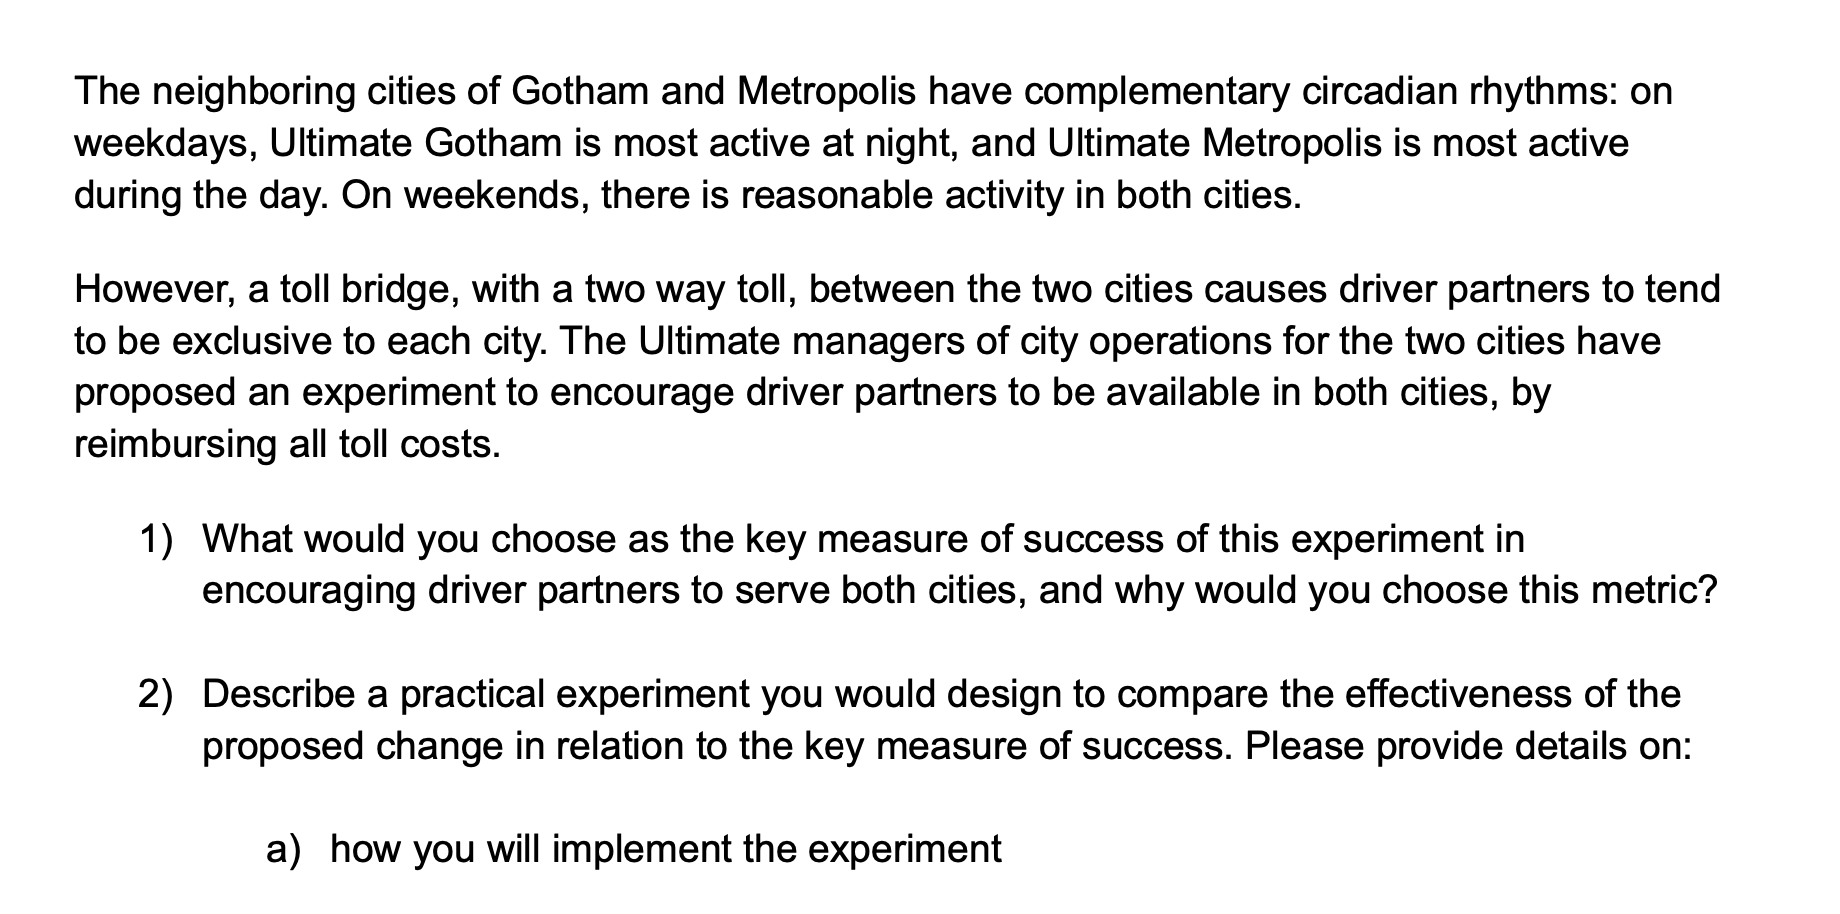
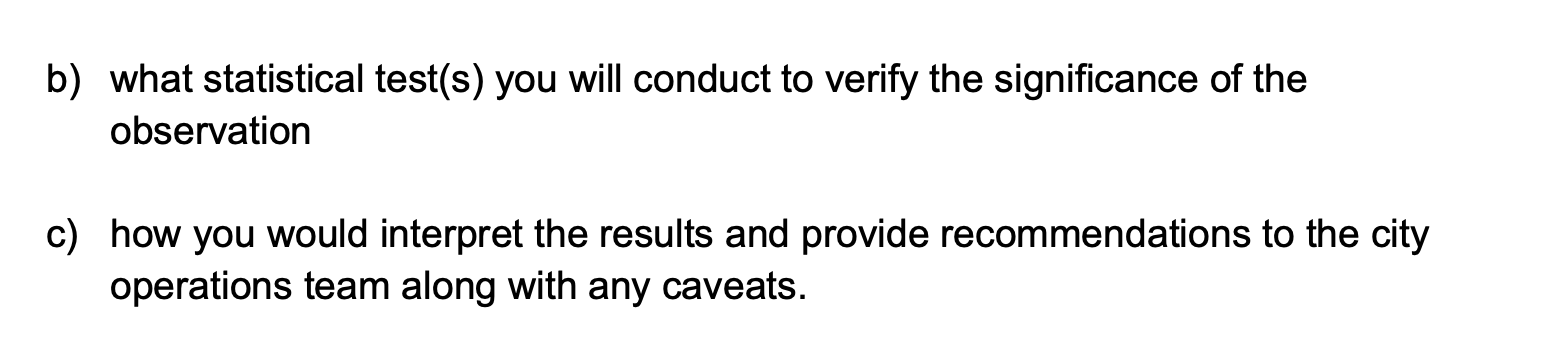

1. To measure the success of this experiment, we will define a metric called 'crossing rate' as such:

    c =  number of times driver crosses bridge per day

    n =  total number of drives per day

    crossing rate = c/n


2. 
    * To conduct the experiment we will take a sample of drivers that favor each city (e.g. 50 from Gotham and 50 from Metropolis). We will calculate the crossing rate for each driver for 30 days prior to the experiment. This data should already be available, so time will not necessarily need to be spent on this. Then we will implement the reimburment of toll costs experiment. After 30 days, we will calculate the crossing rate again. We will then calculate the difference between the two groups, and calculate the mean

    * We have to consider the distributions of our data, that is the distribution of the difference between groups. If the distribution is normal we can use a paired T-test. Otherwise we should use a nonparametric test such as the Wilcoxon Signed rank test. For the sake of this experiemnt we will assume normality conduct a paired T-test to verify the results of this experiement under the following hypotheses:
    
         H0: There is no difference in the mean crossing rate (diff = 0)
         Ha: The difference is greater than 0  (diff > 0)

      We will also need to choose a critical value, to compare our p-value against. We will choose 0.05 (or 5%).

    * If the p-value < 0.05, we can reject the null hypothesis. This suggests statistical evidence that the mean crossing rate increased afted the experiemnt. If the p-value > 0.05, then we fail to reject the null hypothesis. 


# PART 3

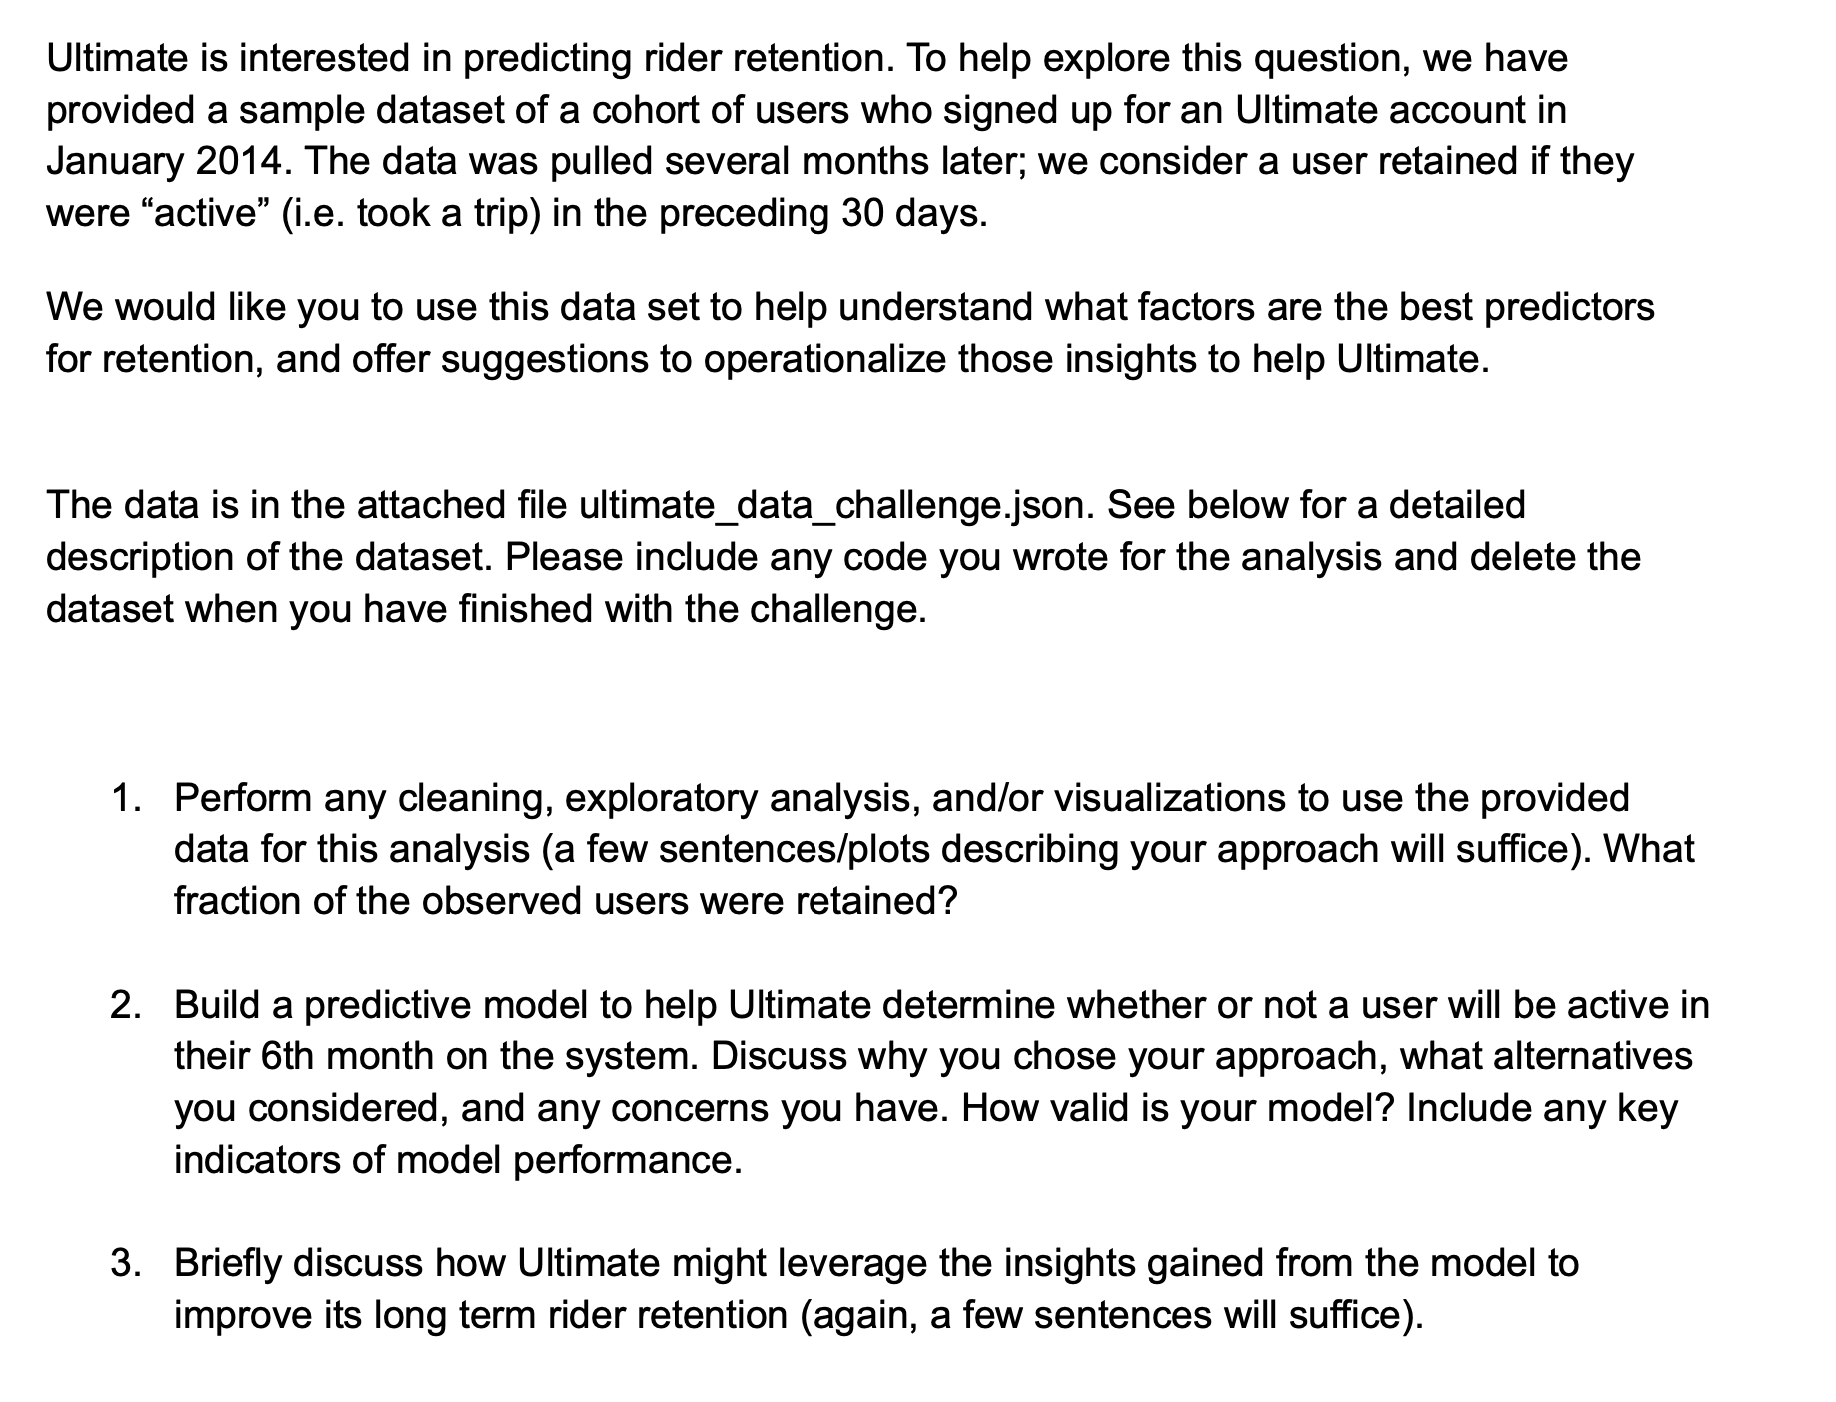

In [72]:
# Load in riders data
riders = pd.read_json('ultimate_data_challenge.json')
riders.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [73]:
# Shape of the data
riders.shape

(50000, 12)

In [74]:
riders.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [75]:
riders['phone'].fillna('unknown', inplace=True)
riders['avg_rating_of_driver'].fillna(0, inplace=True)
riders['avg_rating_by_driver'].fillna(0, inplace=True)

In [76]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [77]:
riders['signup_date'] = pd.to_datetime(riders['signup_date'])
riders['last_trip_date'] = pd.to_datetime(riders['last_trip_date'])


# Defining Target: Retention

In [78]:
riders['retention'] = (riders['last_trip_date'] > '2014-06-01')*1

In [79]:
riders['retention'].value_counts(normalize=True)

retention
0    0.6338
1    0.3662
Name: proportion, dtype: float64

## City

In [80]:
riders['city'].value_counts()

city
Winterfell        23336
Astapor           16534
King's Landing    10130
Name: count, dtype: int64

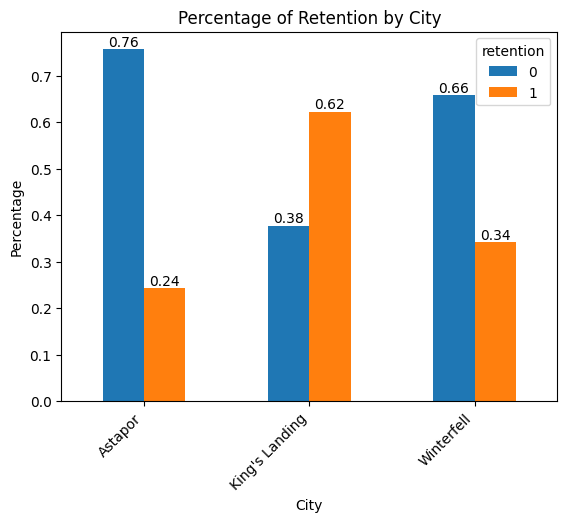

In [81]:
ct = pd.crosstab(index=riders['city'], columns=riders['retention'], normalize='index',)
ax = ct.plot(kind='bar')

for p in ax.patches:
    count = round(p.get_height(), 2)
    ax.annotate(str(count), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
    
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Percentage of Retention by City')
plt.xlabel('City')
plt.ylabel('Percentage')
plt.show()

## Phone

In [82]:
riders['phone'].value_counts()

phone
iPhone     34582
Android    15022
unknown      396
Name: count, dtype: int64

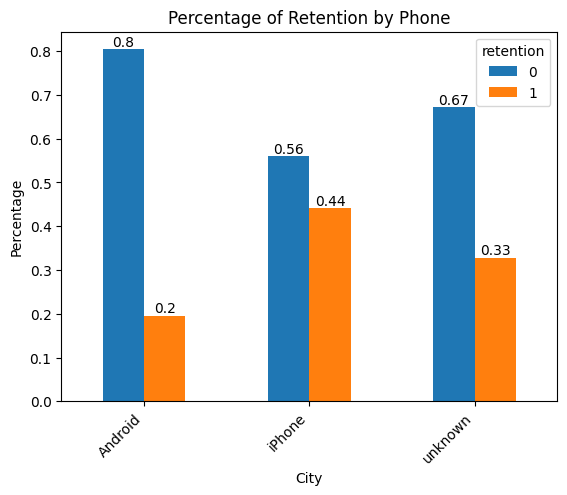

In [83]:
ct = pd.crosstab(index=riders['phone'], columns=riders['retention'], normalize='index',)
ax = ct.plot(kind='bar')

for p in ax.patches:
    count = round(p.get_height(), 2)
    ax.annotate(str(count), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
    
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Percentage of Retention by Phone')
plt.xlabel('City')
plt.ylabel('Percentage')
plt.show()

## ultimate_black_user

In [84]:
riders['ultimate_black_user'].value_counts()

ultimate_black_user
False    31146
True     18854
Name: count, dtype: int64

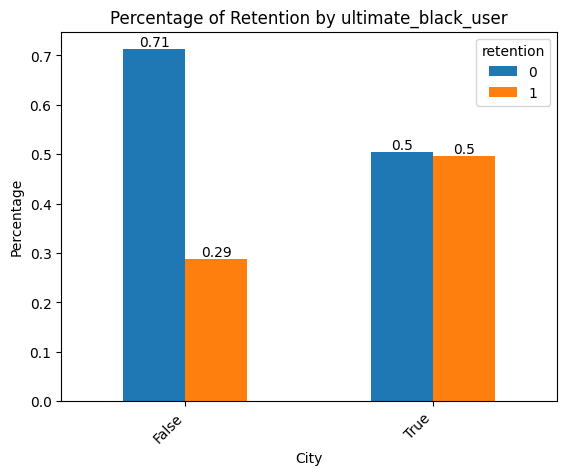

In [85]:
ct = pd.crosstab(index=riders['ultimate_black_user'], columns=riders['retention'], normalize='index',)
ax = ct.plot(kind='bar')

for p in ax.patches:
    count = round(p.get_height(), 2)
    ax.annotate(str(count), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
    
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Percentage of Retention by ultimate_black_user')
plt.xlabel('City')
plt.ylabel('Percentage')
plt.show()

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


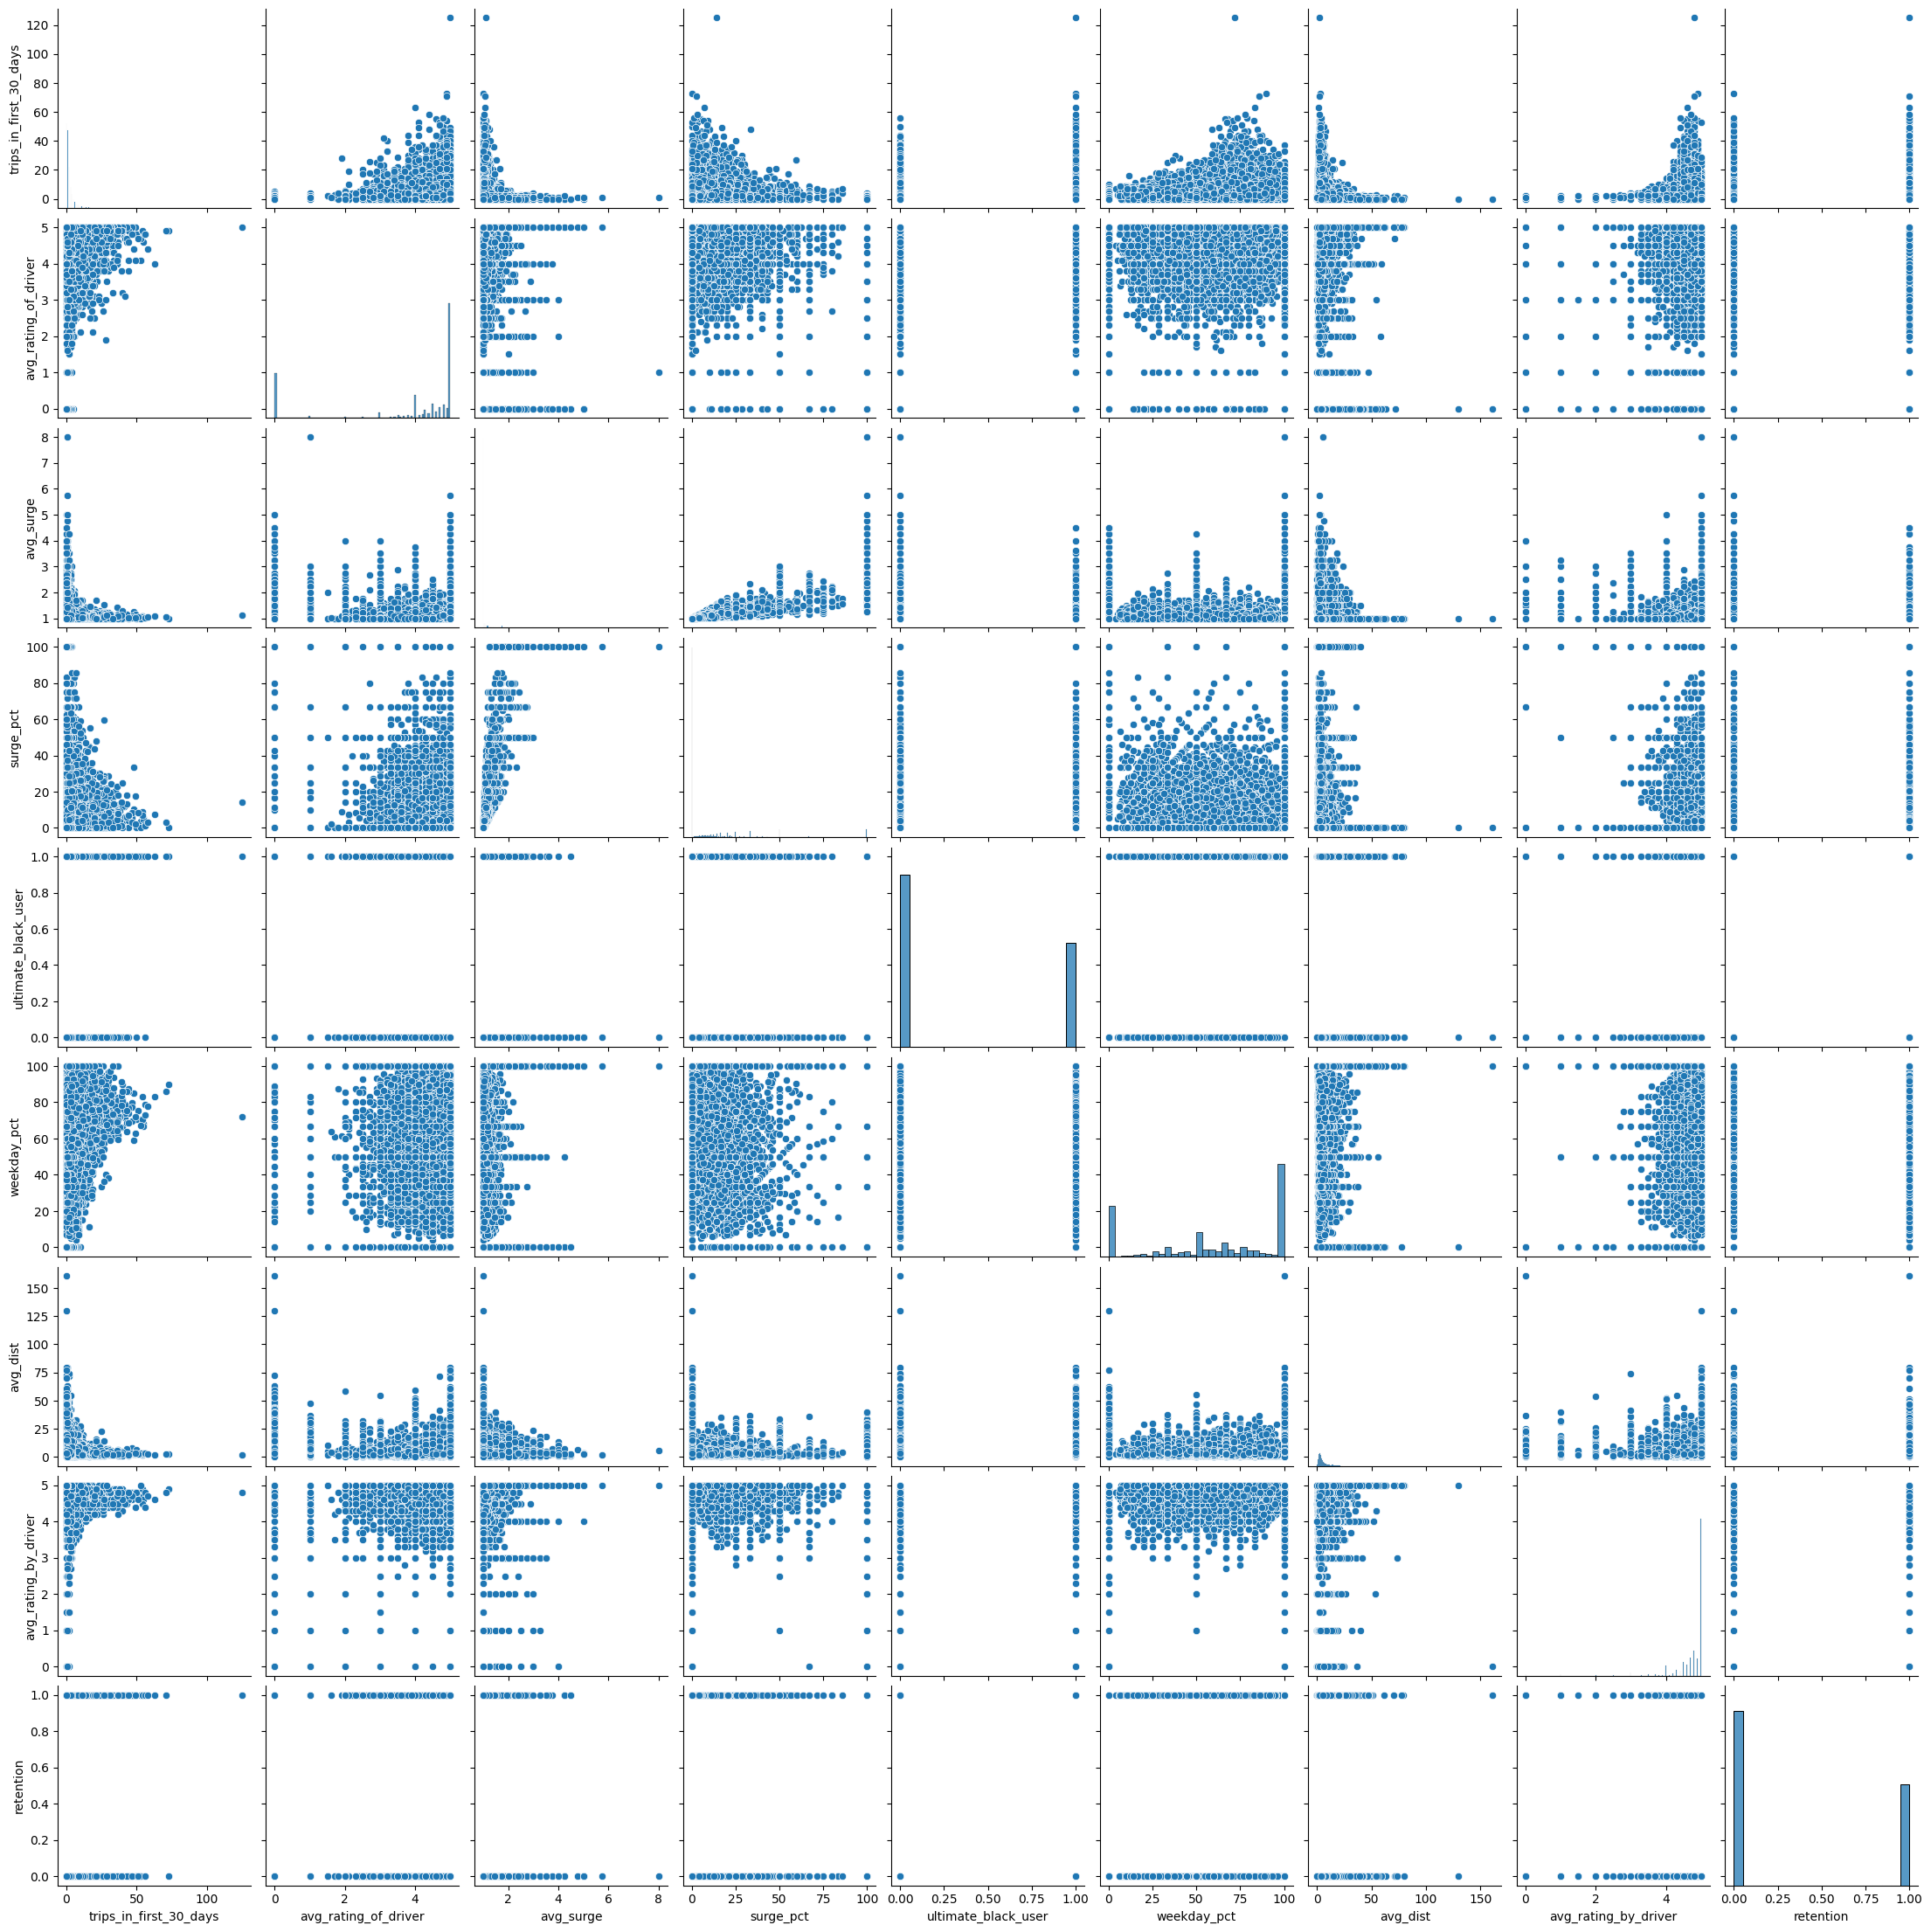

In [86]:
sns.pairplot(riders)

## trips_in_first_30_days

<Axes: xlabel='trips_in_first_30_days', ylabel='Count'>

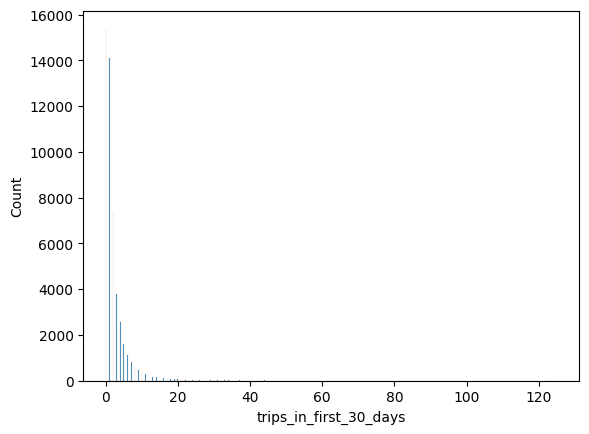

In [87]:
sns.histplot(data=riders, x='trips_in_first_30_days')

In [88]:
riders.groupby('retention')['trips_in_first_30_days'].median()

retention
0    1.0
1    2.0
Name: trips_in_first_30_days, dtype: float64

## avg_rating_of_driver

<Axes: xlabel='avg_rating_of_driver', ylabel='Count'>

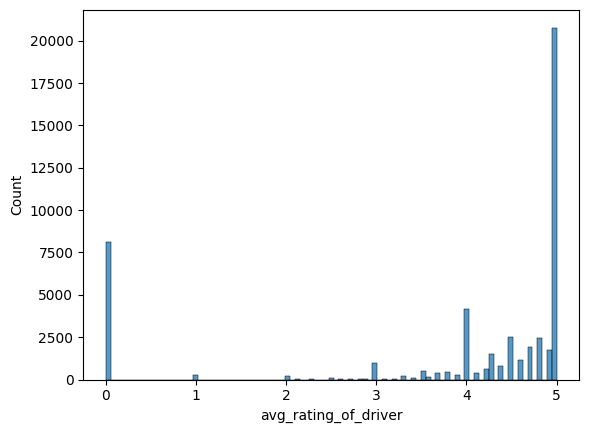

In [89]:
sns.histplot(data=riders, x='avg_rating_of_driver')

In [90]:
riders.groupby('retention')['avg_rating_of_driver'].median()

retention
0    4.8
1    4.7
Name: avg_rating_of_driver, dtype: float64

## avg_surge

(0.0, 1000.0)

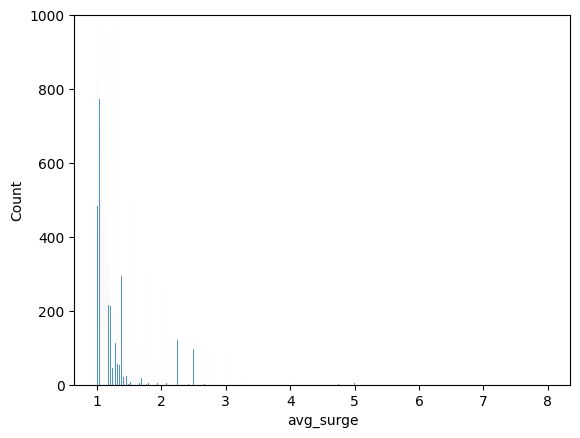

In [91]:
sns.histplot(data=riders, x='avg_surge')
plt.ylim([0, 1000])

In [92]:
riders.groupby('retention')['avg_surge'].median()

retention
0    1.0
1    1.0
Name: avg_surge, dtype: float64

## surge_pct

<Axes: xlabel='surge_pct', ylabel='Count'>

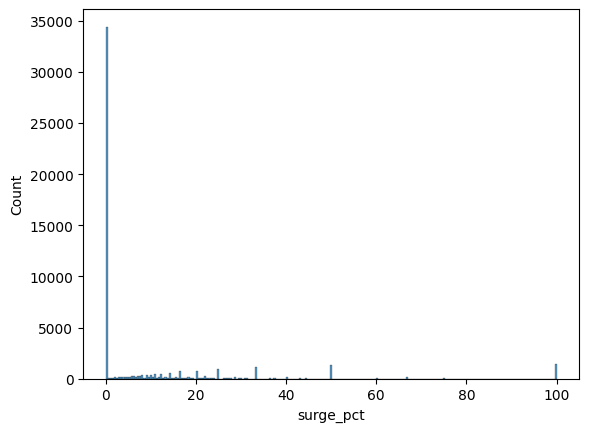

In [93]:
sns.histplot(data=riders, x='surge_pct')


In [94]:
riders.groupby('retention')['surge_pct'].median()

retention
0    0.0
1    0.0
Name: surge_pct, dtype: float64

## weekday_pct

<Axes: xlabel='weekday_pct', ylabel='Count'>

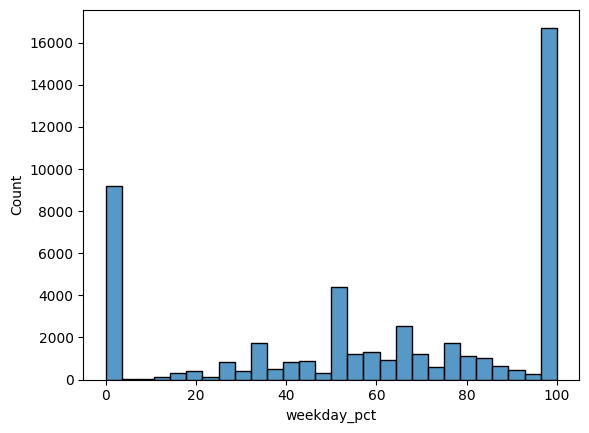

In [95]:
sns.histplot(data=riders, x='weekday_pct')


In [96]:
riders.groupby('retention')['weekday_pct'].median()

retention
0    66.7
1    65.2
Name: weekday_pct, dtype: float64

## avg_dist

<Axes: xlabel='avg_dist', ylabel='Count'>

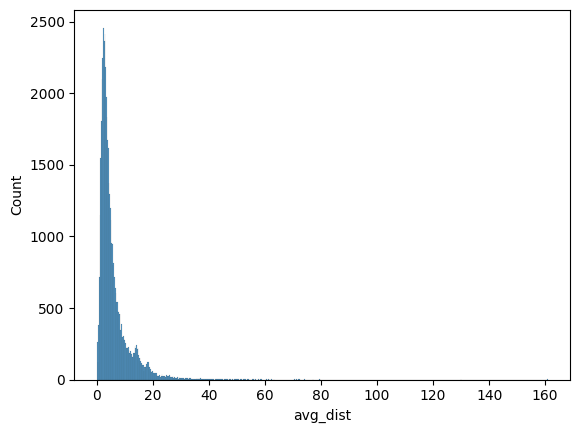

In [97]:
sns.histplot(data=riders, x='avg_dist')


In [98]:
riders.groupby('retention')['avg_dist'].median()

retention
0    4.03
1    3.73
Name: avg_dist, dtype: float64

## avg_rating_by_driver

<Axes: xlabel='avg_rating_by_driver', ylabel='Count'>

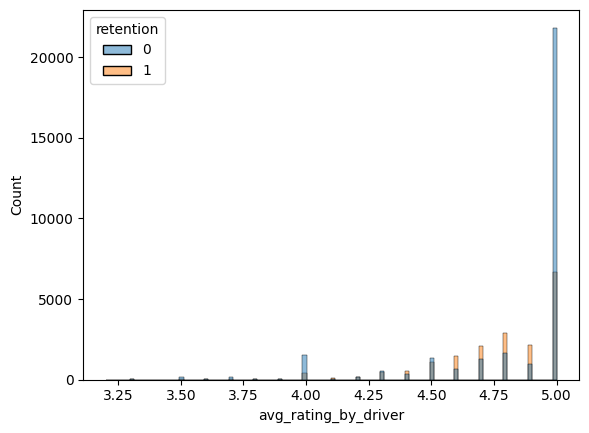

In [131]:
sns.histplot(data=riders.query('avg_rating_by_driver > 3.0'), x='avg_rating_by_driver', hue='retention')


In [133]:
riders.groupby('retention')['avg_rating_by_driver'].median()

retention
0    5.0
1    4.8
Name: avg_rating_by_driver, dtype: float64

In [135]:
pd.crosstab(index=riders['avg_rating_by_driver'], columns=riders['retention'], normalize='index')


retention,0,1
avg_rating_by_driver,,
0.0,0.830846,0.169154
1.0,0.889503,0.110497
1.5,0.750000,0.250000
2.0,0.880952,0.119048
2.3,1.000000,0.000000
2.5,0.967742,0.032258
2.7,1.000000,0.000000
2.8,0.333333,0.666667
3.0,0.873754,0.126246


In [136]:
riders['avg_rating_by_driver'].value_counts()

avg_rating_by_driver
5.0    28508
4.8     4537
4.7     3330
4.9     3094
4.5     2424
4.6     2078
4.0     1914
4.3     1018
4.4      860
3.0      602
4.2      342
0.0      201
3.5      199
3.7      195
1.0      181
2.0      126
4.1      125
3.8      111
3.3       47
3.9       41
2.5       31
3.6       19
3.4        5
1.5        4
2.8        3
3.2        2
2.7        2
2.3        1
Name: count, dtype: int64

In [137]:
riders.query('avg_rating_by_driver == 5')

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retention
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0,1
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49990,Astapor,1,2014-01-13,4.7,1.08,2014-05-18,iPhone,33.3,True,33.3,3.38,5.0,0
49991,Winterfell,0,2014-01-08,5.0,1.25,2014-06-29,iPhone,100.0,False,0.0,1.06,5.0,1
49992,King's Landing,1,2014-01-18,1.0,1.00,2014-01-19,iPhone,0.0,False,0.0,7.58,5.0,0
49997,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,0


# Modeling

In [101]:
X = riders.drop(['signup_date','last_trip_date','retention'], axis=1)
y = riders['retention']

In [102]:
X = pd.get_dummies(X, columns = ['ultimate_black_user','city','phone'],drop_first=True, dtype=int)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [104]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 12)
(10000, 12)
(40000,)
(10000,)


In [105]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6338
           1       0.74      0.66      0.70      3662

    accuracy                           0.79     10000
   macro avg       0.78      0.76      0.77     10000
weighted avg       0.79      0.79      0.79     10000



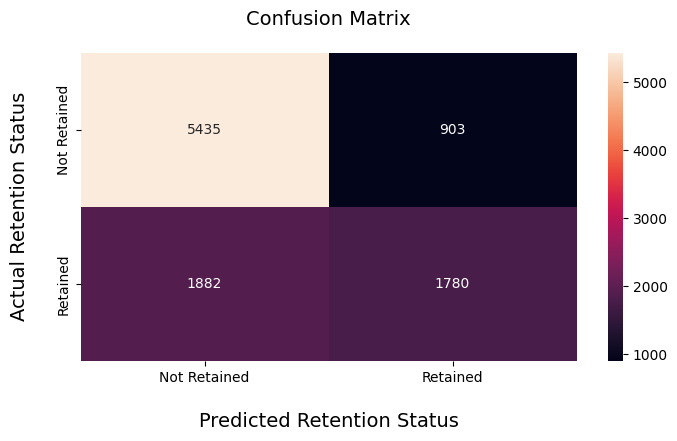

In [126]:
plt.figure(figsize=(8,4))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', )
ax.set_xlabel("Predicted Retention Status", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Not Retained', 'Retained'])
ax.set_ylabel("Actual Retention Status", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Not Retained', 'Retained'])
ax.set_title("Confusion Matrix", fontsize=14, pad=20)
plt.show()

In [107]:
xgb_cv = cross_val_score(xgb, X_train, y_train, cv=5, scoring='f1')

In [108]:
xgb_cv.mean()

0.7022905331312271

<Axes: >

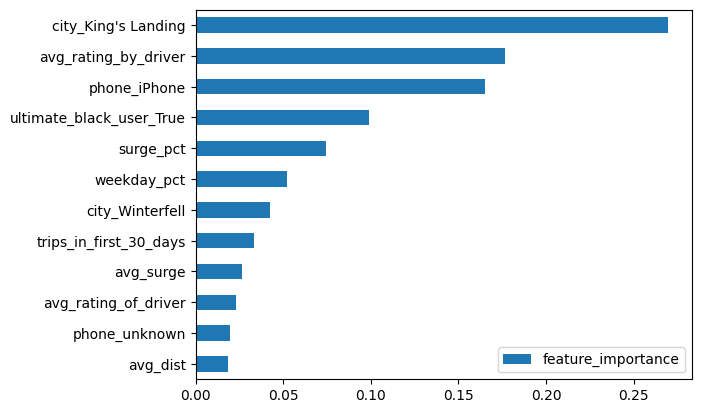

In [109]:
pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['feature_importance'])\
    .sort_values('feature_importance', ascending=True)\
    .plot(kind='barh')

# Answers to Questions

1. Approximately 36% of observed users were retained.

2. The model that was chosen was a XGboost classifier. Logistic Regression and Random Forest Classifiers were also considered, but XGboost outperformed both. The results of the model were validated with 5-fold cross validation, and such I am confident that the model is valid. 

    * Recall = 66%
    * Precision = 74%
    * F1 score = 70%
    
    Because of imbalance in the target classes, pure accuracy is not going to be considered as metric of model performance. Instead, we will look at recall and precision. The recall tells us how many of the retained users were correctly predicted to be in the retained class. The precision tell us how many of the users predicted to be retained, actually were retained. Some of the important features according to the model are city, avg_rating_by_driver, phone, and ultimate_black_user.

    * city: 62% of the users from King's Landing retained, but for Astapor and Winterfell only 24% and 34% retained respectively.
    * avg_rating_by_driver: At first glance, it is unclear why this feature is considered important by the model. But upon deeper EDA of this feature we can see that users with an average rating between 4.6 and 4.9 are more likely to be retained. 
    * phone: 44% of iphone users retained, and only 20% of android users retained.
    * ultimate_black_user: 50% of users part of Ultimate Black were retained, whereas only 29% of users who are not part of it retained.
    

3. Ultimate can leverge the insights gained from the model in a few ways. First, since users from Astapor and Winterfell have such a low retention rate, users from these cities can be targeted with incentives to retain, such as a free month of Ultimate Black. Similarly, since android users also have such a low retention rate, they can be targeted in a similar manner. In general, marketing campaigns targeting users to sign up for Ultimate Black can help retain users. Also, we can encourage drivers to give users a higher rating, as users given a higher rating tend to use the service again. 